## 1. Import Required Libraries

In [1]:
import math
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from typing import Tuple
from pathlib import Path
from tqdm.auto import tqdm

# Add parent directory to path
sys.path.insert(0, "../..")

from hira.index.indexer import CPUIndexer
from hira.index.searcher import CPUSearcher
from hira.benchmark_area.utils.data_loader import get_real_data

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

/home/mohsen/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/home/mohsen/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Configuration and Setup

In [3]:
# Experiment configuration
CONFIG = {
    "num_keys_list": [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000],
    "branching_factors": [4, 8, 16, 32, 64, 128, 256],
    "distributions": ["real"],  # , "uniform", "mixture_of_gaussians", "zipf"],
    "search_chunk_size": 8 * 1024,
    "dim": 128,
    "device": "cpu",
    "target_results": 10,
    "max_iterations": 1,
    "seed": 42,
    "num_runs": 50,  # Number of times to run each experiment
    "real_data_path": "../kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz",
    "output_csv": "benchmark_results.csv",
}

# Results storage
results = []

## Search Function Implementations

In [3]:
def brute_force_search(
    index: CPUIndexer, query: torch.Tensor, threshold: float
) -> torch.Tensor:
    query_norm = query / torch.norm(query, p=2)
    scores = torch.matmul(index.keys, query_norm)
    result = (scores >= threshold).nonzero(as_tuple=True)[0]
    return result


def brute_force_all_scores(index, query, threshold):
    query_norm = query / torch.norm(query, p=2)
    scores = torch.matmul(index.keys, query)
    return scores


def indexed_search(
    index: CPUIndexer, query: torch.Tensor, threshold: float
) -> torch.Tensor:
    searcher = CPUSearcher(chunk_size=CONFIG["search_chunk_size"], numba=False)
    result = searcher.search(query, threshold, index)
    return result


def indexed_search_numba(
    index: CPUIndexer, query: torch.Tensor, threshold: float
) -> torch.Tensor:
    searcher = CPUSearcher(chunk_size=CONFIG["search_chunk_size"], numba=True)
    result = searcher.search(query, threshold, index)
    return result


def run_benchmark(
    keys: torch.Tensor,
    branching_factor: int,
    dim: int,
    device: str,
    max_iterations: int,
    target_results: int,
    num_runs: int = 50,
) -> Tuple[float, float, float, float, float, float, float, float]:
    keys = keys.to(device)

    # Calculate number of levels
    num_levels = math.ceil(math.log(len(keys)) / math.log(branching_factor))

    # Build index (only once)
    config = {
        "num_levels": num_levels,
        "branching_factor": branching_factor,
        "max_iterations": max_iterations,
    }
    index = CPUIndexer(**config)
    index.build(keys)

    # Create query and find threshold (only once)
    query = torch.randn(dim).to(device)
    query_norm = query / torch.norm(query, p=2)
    all_scores = torch.matmul(keys, query_norm)
    sorted_scores, _ = torch.sort(all_scores, descending=True)
    threshold = sorted_scores[min(target_results, len(sorted_scores) - 1)].item()

    # Run multiple times
    bf_times = []
    indexed_times = []
    indexed_numba_times = []
    bf_all_scores_times = []

    for _ in range(10):  # Warm-up runs
        brute_force_search(index, query, threshold)

    for _ in range(num_runs):
        # bf
        start_time = time.time()
        result_bf = brute_force_search(index, query, threshold)
        bf_times.append(time.time() - start_time)

    for _ in range(10):
        brute_force_all_scores(index, query, threshold)

    for _ in range(num_runs):
        # bf all scores
        start_time = time.time()
        result_bf_all = brute_force_all_scores(index, query, threshold)
        bf_all_scores_times.append(time.time() - start_time)

    for _ in range(10):
        indexed_search(index, query, threshold)

    for _ in range(num_runs):
        # Time indexed search
        start_time = time.time()
        result_indexed = indexed_search(index, query, threshold)
        indexed_times.append(time.time() - start_time)

    for _ in range(10):
        indexed_search_numba(index, query, threshold)

    for _ in range(num_runs):
        # Time indexed search with numba
        start_time = time.time()
        result_indexed_numba = indexed_search_numba(index, query, threshold)
        indexed_numba_times.append(time.time() - start_time)

    # Calculate averages and standard deviations
    bf_time_mean = np.mean(bf_times)
    bf_time_std = np.std(bf_times)
    indexed_time_mean = np.mean(indexed_times)
    indexed_time_std = np.std(indexed_times)
    indexed_numba_time_mean = np.mean(indexed_numba_times)
    indexed_numba_time_std = np.std(indexed_numba_times)
    bf_all_scores_times_mean = np.mean(bf_all_scores_times)
    bf_all_scores_times_std = np.std(bf_all_scores_times)

    return (
        bf_time_mean,
        bf_time_std,
        bf_all_scores_times_mean,
        bf_all_scores_times_std,
        indexed_time_mean,
        indexed_time_std,
        indexed_numba_time_mean,
        indexed_numba_time_std,
    )


print("Search functions defined!")

Search functions defined!


## Run Benchmark Experiments

### Load Existing Results (Optional)

In [ ]:
# Uncomment to load existing results instead of running experiments
# df_results = pd.read_csv(CONFIG["output_csv"])

In [ ]:
%%time

results = []
output_csv = Path(CONFIG['output_csv'])

# Calculate total experiments
total_experiments = len(CONFIG['num_keys_list']) * len(CONFIG['branching_factors'])

# Create overall progress bar
overall_pbar = tqdm(total=total_experiments, desc="Overall Progress", position=0, leave=True)


for num_keys in CONFIG['num_keys_list']:
    print(f"\n  Keys: {num_keys:,}")
    
    # Generate data once for this num_keys
    keys = get_real_data(
        num_keys,
        CONFIG['dim'],
        seed=CONFIG['seed'],
        real_data_path=CONFIG['real_data_path']
    )
    
    for branching_factor in CONFIG['branching_factors']:
        bf_time_mean, bf_time_std, bf_all_scores_mean, bf_all_scores_std, indexed_time_mean, indexed_time_std, indexed_numba_time_mean, indexed_numba_time_std = run_benchmark(
            keys,
            branching_factor,
            CONFIG['dim'],
            CONFIG['device'],
            CONFIG['max_iterations'],
            CONFIG['target_results'],
            CONFIG['num_runs']
        )
        
        speedup = bf_time_mean / indexed_time_mean if indexed_time_mean > 0 else 0
        speedup_numba = bf_time_mean / indexed_numba_time_mean if indexed_numba_time_mean > 0 else 0
        
        result = {
            'num_keys': num_keys,
            'branching_factor': branching_factor,
            'brute_force_time_mean': bf_time_mean,
            'brute_force_time_std': bf_time_std,
            'indexed_time_mean': indexed_time_mean,
            'indexed_time_std': indexed_time_std,
            'indexed_numba_time_mean': indexed_numba_time_mean,
            'indexed_numba_time_std': indexed_numba_time_std,
            'bf_all_scores_time_mean': bf_all_scores_mean,
            'bf_all_scores_time_std': bf_all_scores_std,
            'speedup': speedup,
            'speedup_numba': speedup_numba,
            'num_runs': CONFIG['num_runs']
        }
        
        results.append(result)
        
        # Save intermediate results to CSV after each experiment
        pd.DataFrame(results).to_csv(output_csv, index=False)

# Convert to DataFrame
df_results = pd.DataFrame(results)
print(f"\nResults saved to: {output_csv.absolute()}")

## Visualization: Best Performance vs Number of Keys

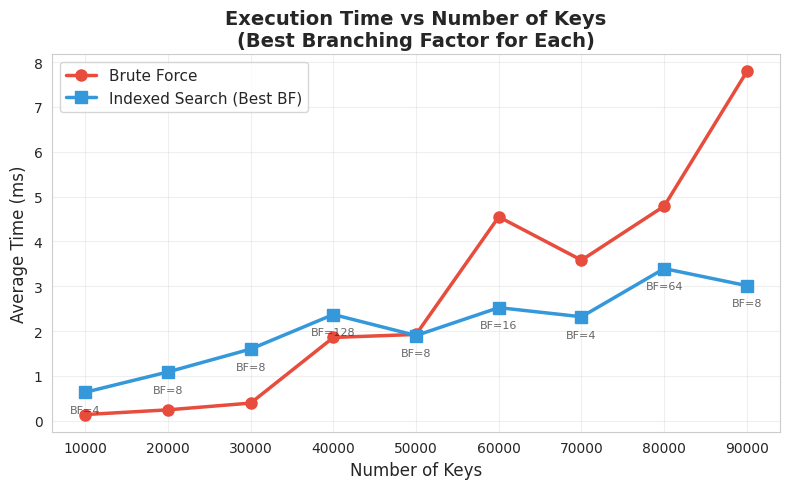

In [10]:
plt.figure(figsize=(8, 5))

# For each num_keys, find the branching factor with the highest speedup
best_results = []
for num_keys in sorted(df_results["num_keys"].unique()):
    df_nk = df_results[df_results["num_keys"] == num_keys]
    # Find row with maximum speedup
    best_row = df_nk.loc[df_nk["speedup"].idxmax()]
    best_results.append(
        {
            "num_keys": num_keys,
            "branching_factor": best_row["branching_factor"],
            "brute_force_time": best_row["brute_force_time_mean"]
            * 1000,  # Convert to ms
            "indexed_time": best_row["indexed_time_mean"] * 1000,  # Convert to ms
            "speedup": best_row["speedup"],
        }
    )

df_best = pd.DataFrame(best_results)

# Plot both lines
plt.plot(
    df_best["num_keys"],
    df_best["brute_force_time"],
    marker="o",
    linestyle="-",
    linewidth=2.5,
    markersize=8,
    color="#e74c3c",
    label="Brute Force",
)

plt.plot(
    df_best["num_keys"],
    df_best["indexed_time"],
    marker="s",
    linestyle="-",
    linewidth=2.5,
    markersize=8,
    color="#3498db",
    label="Indexed Search (Best BF)",
)

plt.xlabel("Number of Keys", fontsize=12)
plt.ylabel("Average Time (ms)", fontsize=12)
plt.title(
    "Execution Time vs Number of Keys\n(Best Branching Factor for Each)",
    fontsize=14,
    fontweight="bold",
)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
# plt.yscale("log")

# Add annotations for branching factors
for idx, row in df_best.iterrows():
    plt.annotate(
        f"BF={int(row['branching_factor'])}",
        xy=(row["num_keys"], row["indexed_time"]),
        xytext=(0, -15),
        textcoords="offset points",
        fontsize=8,
        ha="center",
        alpha=0.7,
    )

plt.tight_layout()
# plt.savefig("benchmark_best_speed_vs_num_keys.png", dpi=300)
plt.show()

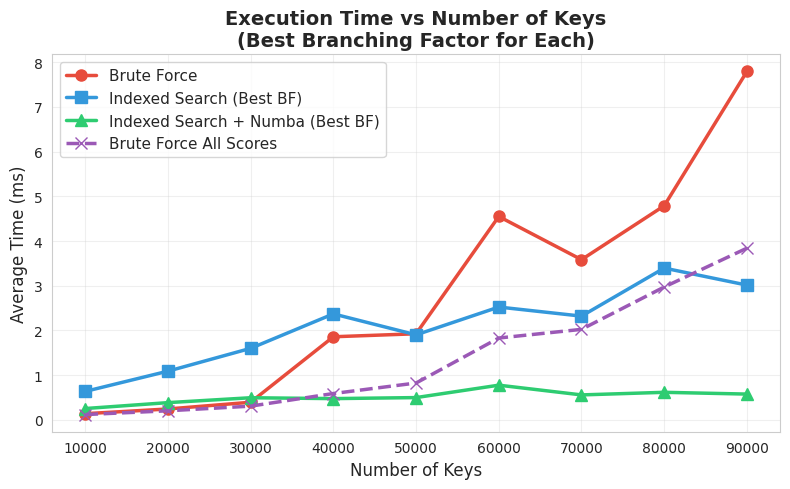

In [15]:
# ...existing code...

plt.figure(figsize=(8, 5))

best_results = []
for num_keys in sorted(df_results["num_keys"].unique()):
    df_nk = df_results[df_results["num_keys"] == num_keys]

    # Best BF for indexed (speedup)
    best_row = df_nk.loc[df_nk["speedup"].idxmax()]
    # Best BF for numba indexed (speedup_numba)
    best_row_numba = df_nk.loc[df_nk["speedup_numba"].idxmax()]

    best_results.append(
        {
            "num_keys": num_keys,
            "branching_factor": best_row["branching_factor"],
            "branching_factor_numba": best_row_numba["branching_factor"],
            "brute_force_time": best_row["brute_force_time_mean"] * 1000,
            "indexed_time": best_row["indexed_time_mean"] * 1000,
            "indexed_numba_time": best_row_numba["indexed_numba_time_mean"] * 1000,
            "bf_all_scores_time": best_row["bf_all_scores_time_mean"] * 1000,
        }
    )

df_best = pd.DataFrame(best_results)

plt.plot(
    df_best["num_keys"],
    df_best["brute_force_time"],
    marker="o",
    linestyle="-",
    linewidth=2.5,
    markersize=8,
    color="#e74c3c",
    label="Brute Force",
)

plt.plot(
    df_best["num_keys"],
    df_best["indexed_time"],
    marker="s",
    linestyle="-",
    linewidth=2.5,
    markersize=8,
    color="#3498db",
    label="Indexed Search (Best BF)",
)

plt.plot(
    df_best["num_keys"],
    df_best["indexed_numba_time"],
    marker="^",
    linestyle="-",
    linewidth=2.5,
    markersize=8,
    color="#2ecc71",
    label="Indexed Search + Numba (Best BF)",
)

plt.plot(
    df_best["num_keys"],
    df_best["bf_all_scores_time"],
    marker="x",
    linestyle="--",
    linewidth=2.5,
    markersize=8,
    color="#9b59b6",
    label="Brute Force All Scores",
)

plt.xlabel("Number of Keys", fontsize=12)
plt.ylabel("Average Time (ms)", fontsize=12)
plt.title(
    "Execution Time vs Number of Keys\n(Best Branching Factor for Each)",
    fontsize=14,
    fontweight="bold",
)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Annotate best BFs for both indexed lines
# for _, row in df_best.iterrows():
#     plt.annotate(
#         f"BF={int(row['branching_factor'])}",
#         xy=(row["num_keys"], row["indexed_time"]),
#         xytext=(0, -15),
#         textcoords="offset points",
#         fontsize=8,
#         ha="center",
#         alpha=0.7,
#         color="#3498db",
#     )
#     plt.annotate(
#         f"BF={int(row['branching_factor_numba'])}",
#         xy=(row["num_keys"], row["indexed_numba_time"]),
#         xytext=(0, 8),
#         textcoords="offset points",
#         fontsize=8,
#         ha="center",
#         alpha=0.7,
#         fontweight="bold",
#         color="#2ecc71",
#     )

plt.tight_layout()
# plt.savefig("benchmark_best_speed_vs_num_keys.png", dpi=300)
plt.show()